<a href="https://colab.research.google.com/github/amsalugetasew/python_projects/blob/main/Age_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

In [2]:
#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

In [3]:
#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

In [10]:
#Warningds
import warnings
warnings.filterwarnings('ignore')

In [29]:
train_data_path = ('/content/drive/MyDrive/Training_Dataset/train');
# '/kaggle/input/age-detection-human-faces-18-60-years/train'

filepaths =[]
labels = []



In [30]:
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)



In [32]:
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [33]:
train_df

,filepaths,label
0,/content/drive/MyDrive/Training_Dataset/train/...,21-30
1,/content/drive/MyDrive/Training_Dataset/train/...,21-30
2,/content/drive/MyDrive/Training_Dataset/train/...,21-30
3,/content/drive/MyDrive/Training_Dataset/train/...,18-20
4,/content/drive/MyDrive/Training_Dataset/train/...,18-20
5,/content/drive/MyDrive/Training_Dataset/train/...,18-20
6,/content/drive/MyDrive/Training_Dataset/train/...,18-20
7,/content/drive/MyDrive/Training_Dataset/train/...,18-20
8,/content/drive/MyDrive/Training_Dataset/train/...,41-50
9,/content/drive/MyDrive/Training_Dataset/train/...,41-50


In [34]:
test_data_path = '/content/drive/MyDrive/Training_Dataset/test'
filepaths =[]
labels = []

In [35]:
folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [36]:
test_df

,filepaths,label
0,/content/drive/MyDrive/Training_Dataset/test/1...,18-20
1,/content/drive/MyDrive/Training_Dataset/test/1...,18-20
2,/content/drive/MyDrive/Training_Dataset/test/1...,18-20
3,/content/drive/MyDrive/Training_Dataset/test/1...,18-20
4,/content/drive/MyDrive/Training_Dataset/test/1...,18-20


In [37]:
#Spliting data into valid and test
valid,test = train_test_split(test_df,train_size=0.5,shuffle=True,random_state=42)

In [38]:
#Image Data Generator
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 20 validated image filenames belonging to 5 classes.
Found 2 validated image filenames belonging to 1 classes.
Found 3 validated image filenames belonging to 1 classes.


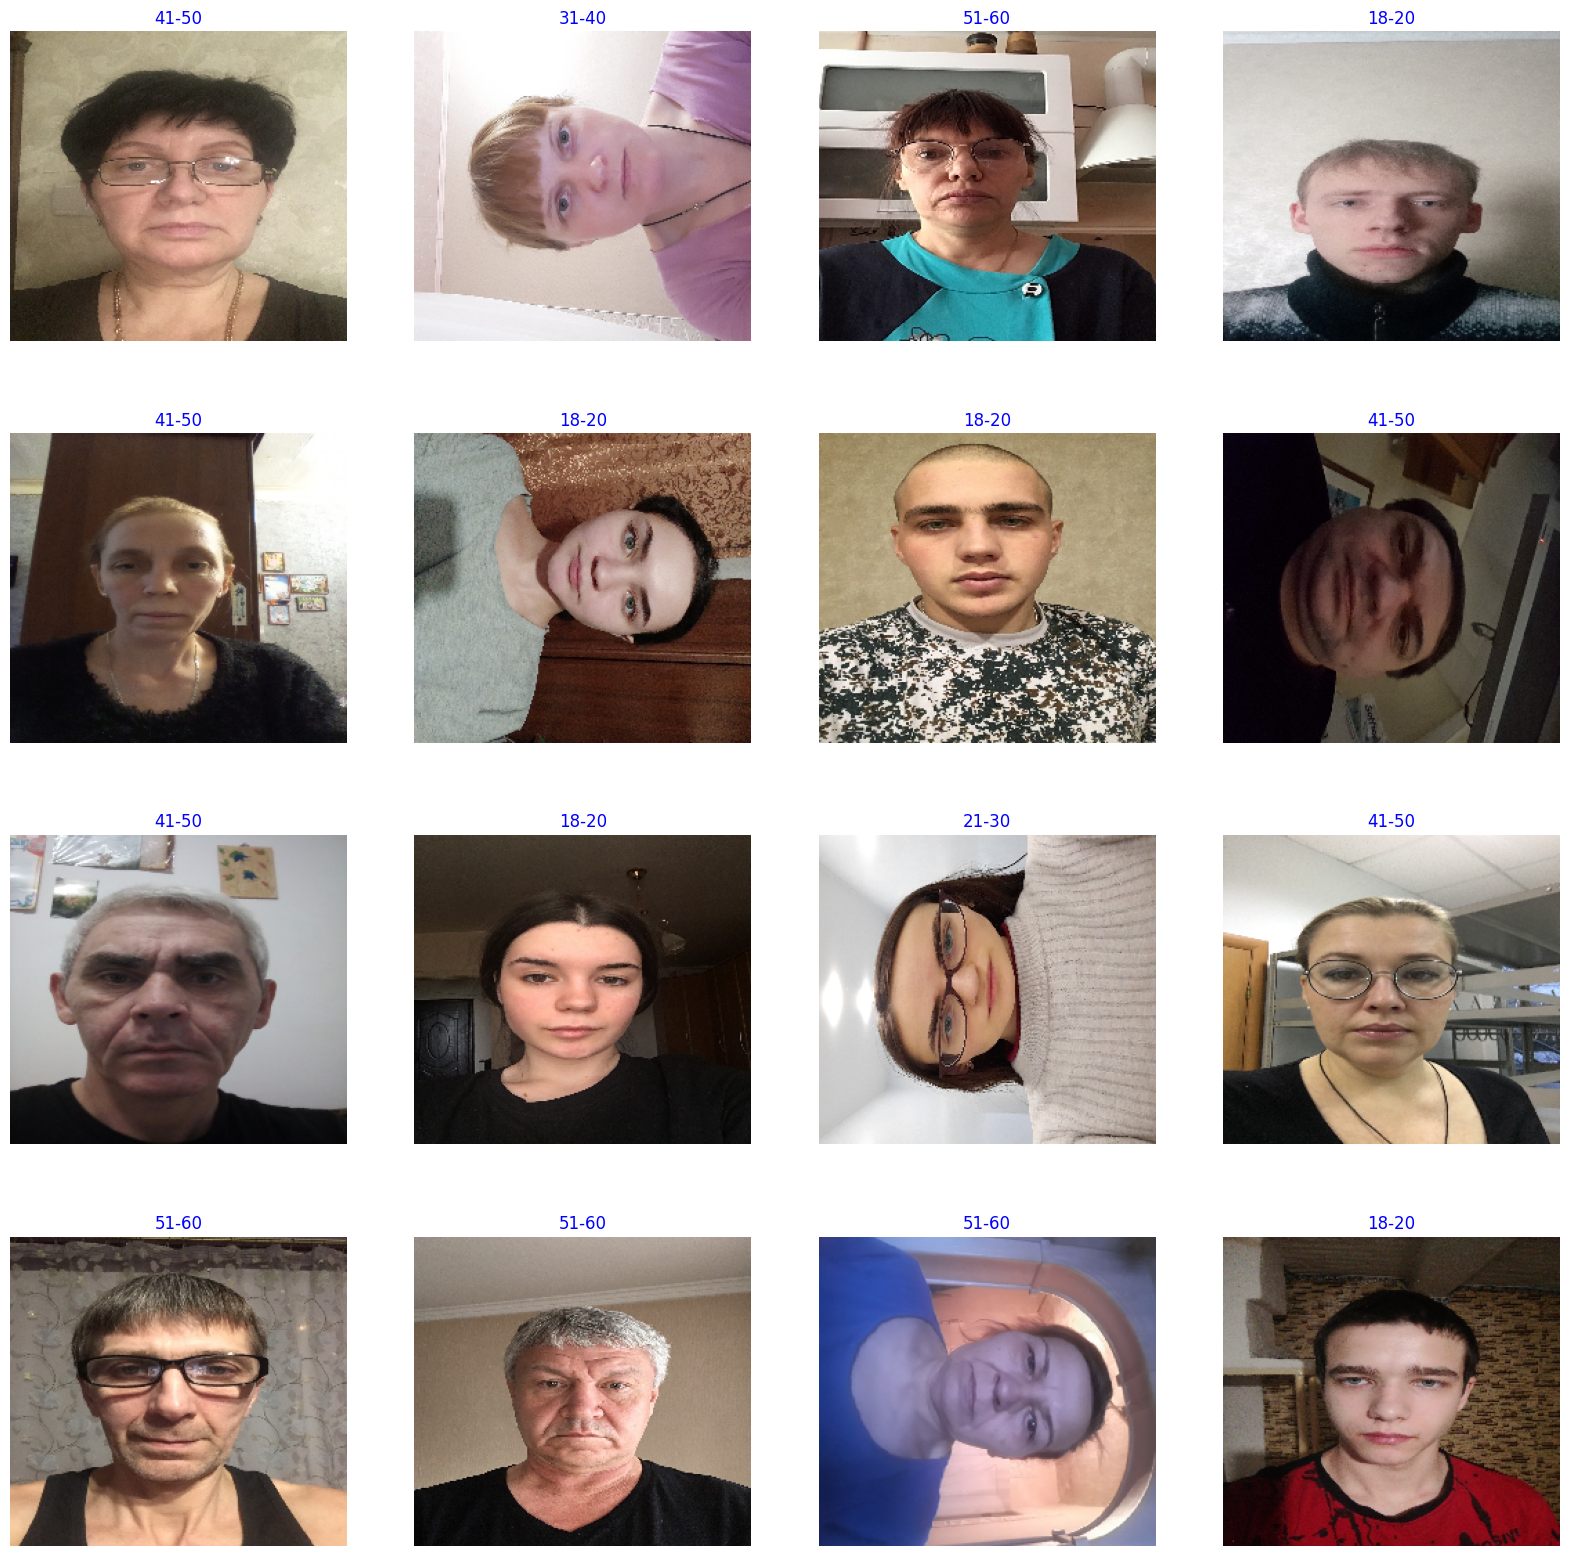

In [39]:
#Show sample from train data
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [40]:
#Model
img_shape = (img_size[0],img_size[1],3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                         

In [41]:
#Iteration
epochs = 10
history = model.fit(x= train_gen , epochs = epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10
2/2 [==============================] - 59s 7s/step - loss: 9.6564 - accuracy: 0.4000 - val_loss: 22.0773 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 17s 3s/step - loss: 8.2473 - accuracy: 0.9000 - val_loss: 24.2802 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 15s 3s/step - loss: 7.9874 - accuracy: 0.9000 - val_loss: 23.8902 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 15s 3s/step - loss: 7.9565 - accuracy: 0.9500 - val_loss: 24.6718 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 15s 4s/step - loss: 7.7973 - accuracy: 1.0000 - val_loss: 25.3599 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 13s 4s/step - loss: 7.8272 - accuracy: 0.9000 - val_loss: 26.0926 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 14s 3s/step - loss: 7.6844 - accuracy: 1.0000 - val_loss: 26.3659 - val_accuracy: 0.0000e+00

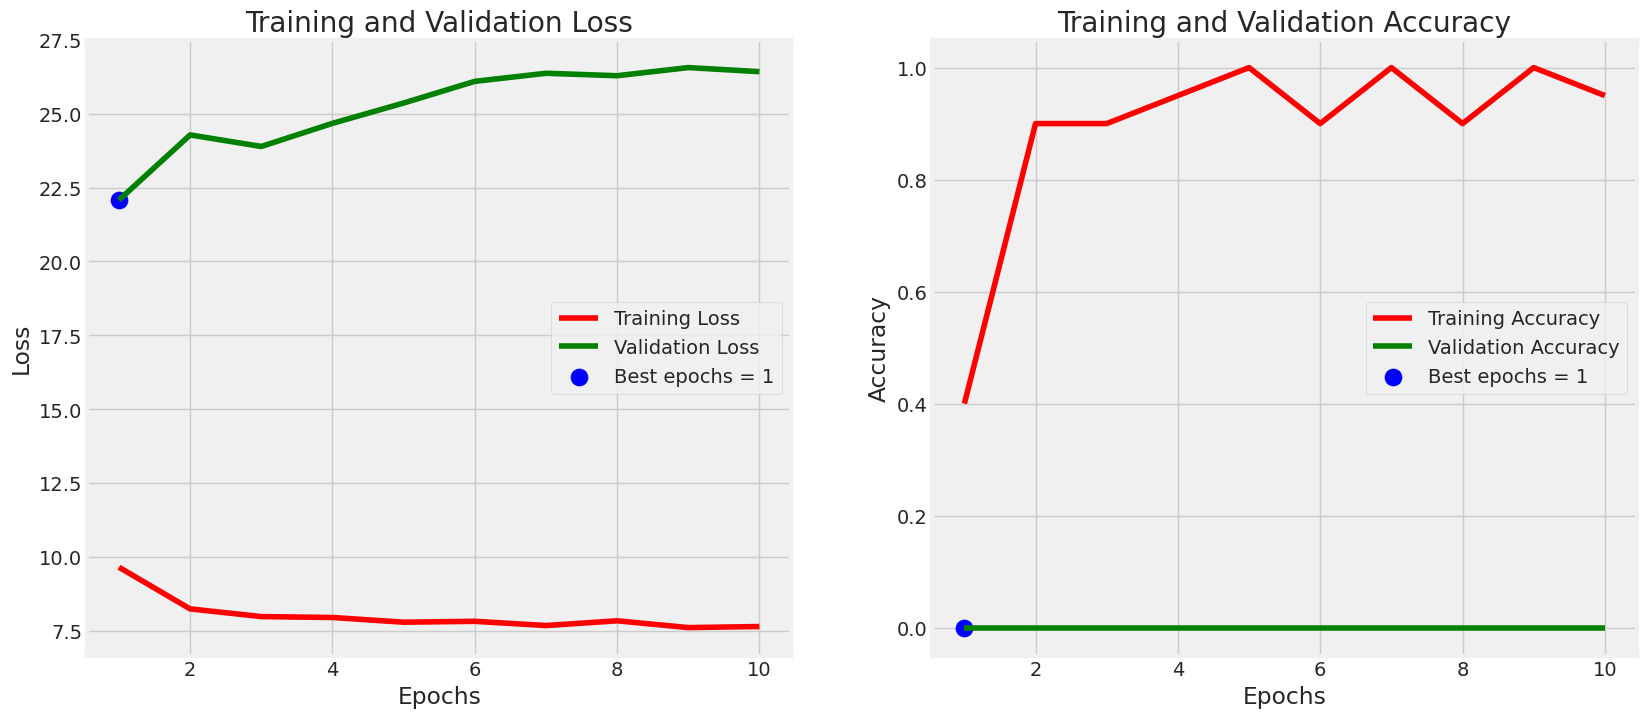

In [42]:
#Model Performance
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [43]:
#Model Evaluation
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

 2/16 [==>...........................] - ETA: 10s - loss: 8.9368 - accuracy: 0.9000 

 1/16 [>.............................] - ETA: 6s - loss: 26.4203 - accuracy: 0.0000e+00

 1/16 [>.............................] - ETA: 9s - loss: 32.9185 - accuracy: 0.0000e+00

16/16 [==============================] - 1s 4ms/step - loss: 32.9185 - accuracy: 0.0000e+00
Train Loss:  8.936769485473633
Train Accuracy:  0.8999999761581421
--------------------
Validation Loss:  26.4202938079834
Validation Accuracy:  0.0
--------------------
Test Loss:  32.91848373413086
Test Accuracy:  0.0


In [44]:
#Model prediction
#Confusion Matrix and Classification report
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds,axis=1)

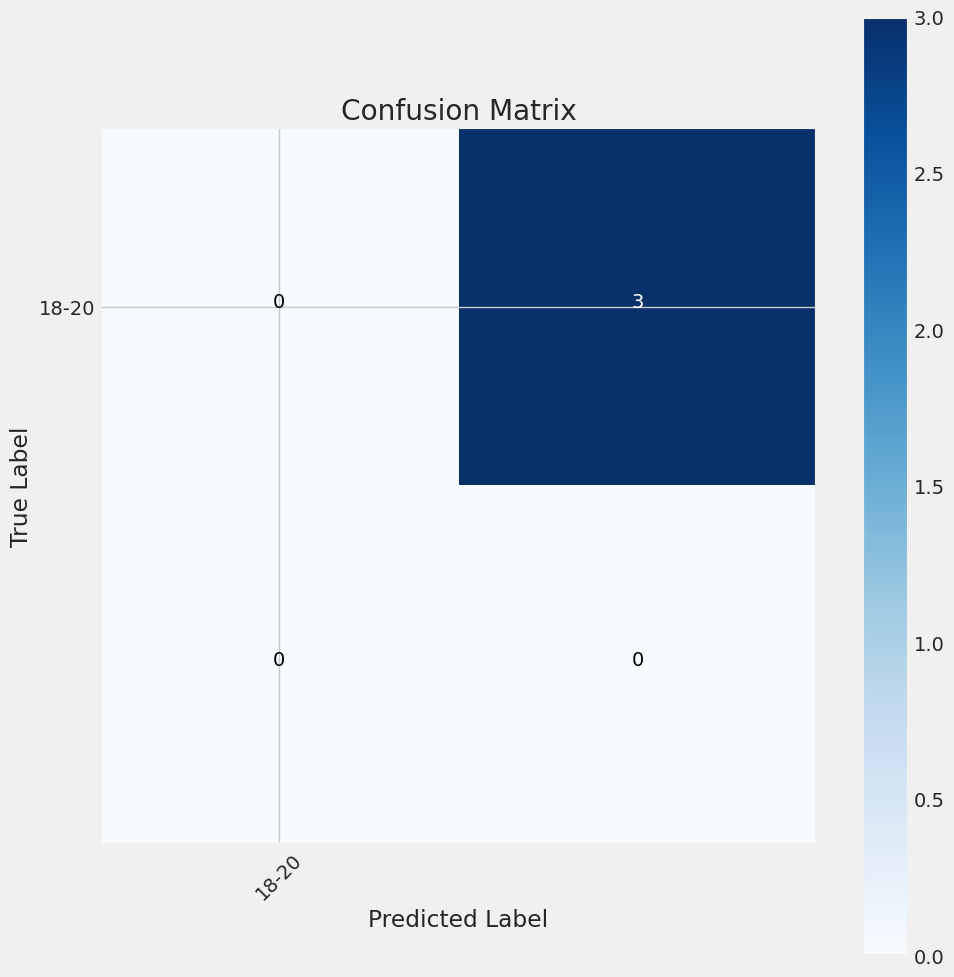

In [45]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [46]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

ValueError: ignored

In [ ]:
resize = 224
label = ("18-20","21-30","31-40","41-50","51-60")

In [ ]:
image1 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/18-20/25.jpg")
image2 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/21-30/27.jpg")
image3 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/31-40/29.jpg")
image4 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/41-50/26.jpg")
image5 = Image.open("/kaggle/input/age-detection-human-faces-18-60-years/test/51-60/26.jpg")


plt.figure('image1')
plt.title("18-20")
plt.imshow(image1)

plt.figure('image2')
plt.title("21-30")
plt.imshow(image2)


plt.figure("image3")
plt.title("31-40")
plt.imshow(image3)

plt.figure("image4")
plt.title("41-50")
plt.imshow(image4)

plt.figure("image5")
plt.title("51-60")
plt.imshow(image5)